<a href="https://colab.research.google.com/github/epi2me-labs/tutorials/blob/master/Introduction_to_Variant_Call_Format_(vcf)_files.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Introduction to Variant Call Format (.vcf) files</h1>

The tutorial provides a short introduction to [Variant Call Format](https://en.wikipedia.org/wiki/Variant_Call_Format) files used in bioinformatics to store differences between the DNA sequence of a sample and that of a reference sequence.

Methods used in this tutorial include:

* `pysam` for iterating through VCF files,
* `pandas` for manipulating VCF files as a table, and
* `bcftools` for filtering VCF files on the command-line.

The computational requirements for this tutorial are:

* A computer running the EPI2ME Labs Server environment,
* 8Gb RAM.

> ⚠️ **Warning:** This notebook has been saved with its outputs for demostration purposed. It is recommeded to select `Edit > Clear all outputs` before using the notebook to analyse your own data.



In [ ]:
#TODO: remove
#!pip uninstall -y aplanat
#!cd /epi2melabs/aplanat && python setup.py develop
%load_ext autoreload
%autoreload 2

## Introduction

This tutorial aims to elucidate the information stored with a Variant Call Format (VCF) file, and how such files can be read, or parsed, within the Python programming language and on the command line.

The goals from this tutorial include:

* Understand the basic concepts of a Variant Call Format (VCF),
* Know how to manipulate a VCF file as a simple table,
* Be able to iterate through records of a VCF using `pysam`, and
* Have an awareness of command-line tools which can be used to manipulate VCF files.

The tutorial includes a sample VCF file output by [medaka](https://github.com/nanoporetech/medaka) from whole genome sequencing of the Genome in a Bottle ([GIAB](https://www.nist.gov/programs-projects/genome-bottle)) HG002 sample.

## Getting started

⚠️  ***Reminder:*** Connect to your locally running EPI2ME Labs Server before running any of the code below. See [Run a tutorial](https://colab.research.google.com/github/epi2me-labs/resources/blob/master/epi2me-labs-server.ipynb#scrollTo=r--DdCunUR6Y) on the EPI2ME Labs Server help page for more information.

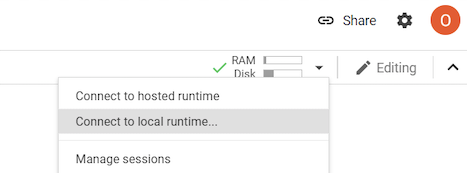

Having connected to the EPI2ME Labs Server, before anything else we will create and set a working directory:

In [ ]:
from epi2melabs import ping
tutorial_name = "vcf-tutorial"
pinger = ping.Pingu()
pinger.send_notebook_ping('start', tutorial_name)

# create a work directory and move into it
working_dir = '/epi2melabs/{}/'.format(tutorial_name)
!mkdir -p "$working_dir"
%cd "$working_dir"

/epi2melabs/vcf-tutorial


### Sample Data

In order to provide a concrete example of handling a long-read VCF file this tutorial is provided with an example file produced by Oxford Nanopore Technologies' consensus and variant calling program Medaka.

To download the sample file we run the `linux` command `wget`. To execute the command click on the cell and then press Command/Ctrl-Enter, or click the Play symbol to the left-hand side.

In [ ]:
bucket = "ont-exd-int-s3-euwst1-epi2me-labs"
domain = "s3-eu-west-1.amazonaws.com"
site = "https://{}.{}".format(bucket, domain)
site = "https://ont-exd-int-s3-euwst1-epi2me-labs.s3-eu-west-1.amazonaws.com"

!mkdir -p sample_data
!cd sample_data && wget -O medaka.vcf.gz.tbi $site/vcf_tutorial/ont_hg002/medaka.vcf.gz.tbi
!cd sample_data && wget -O medaka.vcf.gz $site/vcf_tutorial/ont_hg002/medaka.vcf.gz

### Data entry

Having downloaded the sample data we need to provide the filepaths as input to the notebook.

The form can be used to enter the filenames of your inputs. Alternatively you can edit the code which reads the inputs by first double clicking the form header. After entering your inputs (or editing the code cell) remember to execute the code using `Command/Ctrl-Enter`, or pressing the `Play` symbol to the left-hand side.

In [ ]:
#@markdown Enter the paths to the input file and output folder here.

# set variables for our inputs
input_file = '/epi2melabs/vcf-tutorial/sample_data/medaka.vcf.gz'  #@param {type: "string"}
output_folder = 'analysis'  #@param {type: "string"}

# run a command to concatenate all the files together
!cecho ok "Making output folder"
!mkdir -p "$output_folder"
!test -f "$input_file" \
    && cecho success " - Found input file." \
    || cecho error " - Input file does not exist."

# create index file
!cecho ok "Creating index file"
!tabix -f /epi2melabs/vcf-tutorial/sample_data/medaka.vcf.gz \
    && cecho success " - Successfully created index." \
    || cecho error " - Failed to create index file."

Making output folder
 - Found input file.
Creating index file
 - Successfully created index.


Executing the above form will have checked input files and attempted to create an index file for the specified VCF file. We will come back to index file later in the tutorial.

## VCF files

Before discussing how to read VCF files in Python we will first review their structure. The formal specification for VCF files can be found [here](https://samtools.github.io/hts-specs/VCFv4.3.pdf). This is a thorough technical document detailing many different use cases.  Here we will focus on a brief introduction to the common elements of all VCF files athough it is rather a turgid document.

To understand a VCF file we must first recall how such a file has been produced. Classically the file will have been created by analysing alignments of sequencing reads to a reference database containing one or more reference sequences. VCF files refer to these reference sequences variously as `contig`s or `CHROM`s.

Variant call format files are a human readable, text-based file format. Very often they will be compressed using a variant of gzip compression. Aside from the header sections they are tabular in nature. The three sections of a VCF file are:

1.   Meta-information lines (prefixed with `##`) containing information helpful for interpreting the rest of the file,
2.   The header line (prefixed with `#`) which labels the columns
3.   Data lines containing the information regarding variants.

For example the start of the medaka VCF looks like:

In [ ]:
# use zcat to decompress the file and head to read the first 20 lines
!zcat $input_file 2>/dev/null | head -n 20

##fileformat=VCFv4.1
##medaka_version=1.0.3
##contig=<ID=chr1>
##INFO=<ID=pos1,Number=.,Type=Integer,Description="POS of incorporated variants from haplotype 1">
##INFO=<ID=q1,Number=1,Type=Float,Description="Combined qual score for haplotype 1">
##INFO=<ID=pos2,Number=.,Type=Integer,Description="POS of incorporated variants from haplotype 2">
##INFO=<ID=q2,Number=1,Type=Float,Description="Combined qual score for haplotype 2">
##FORMAT=<ID=GT,Number=G,Type=String,Description="Genotype">
##FORMAT=<ID=GQ,Number=G,Type=Integer,Description="Genotype quality score">
##CL=medaka_variant -U -o chr1 -m r941_prom_variant_g360 -s r941_prom_snp_g360 -i PAD65442_3.6.1_pass.bam -f GCA_000001405.15_GRCh38_no_alt_analysis_set.fna -r chr1:0-10000000 -t 4; Fri  3 Jul 21:15:23 BST 2020
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	SAMPLE
chr1	10108	.	C	CT	14.91	PASS	pos1=10108;pos2=10108;q1=10.99;q2=18.83	GT:GQ	1|1:15
chr1	10177	.	A	AC	4.852	PASS	pos2=10177;q2=4.852	GT:GQ	0|1:5
chr1	10257	.	A	C	0.799	PA

We see that the meta-information lines are all of the form:

```
##key=value
```

The first of these is always a line describing the specific version of the format of the file, in this case version 4.1 of VCF (`fileformat=VCFv4.1`). Next we have a line stating the version of Medaka used to produce the VCF file, this line is bespoke to VCF files produced by Medaka. The third meta-information line `contig=<ID=chr1>` describes the fact that there could be variants in the file lying on the sequence named `chr1`. There will be as many such lines as there are unique sequences in the reference database to which the VCF file refers.

We then have a set of lines which look like:
```
##INFO=<ID=...,Description="...">
```
These lines describe the contents and datatypes of the `INFO` field of the data section of the file, we will return to these shortly. Following the `INFO` meta-information descriptors we have a similar set of `FORMAT` descriptors of the form:
```
##FORMAT=<ID=,...,Description="...">
```
Similarly these describe the contents of the sample columns in the data section: a VCF file can have one of more sample columns, the Medaka VCF has a single sample column named (appropriately, or confusingly) `SAMPLE`.

A final meta-infomation field `CL` describes the command-line program and options used to produce the VCF file.

We see therefore that the meta-information section although optional in the VCF file specification, is rather crucial for understanding the contents of the rest of the file. Some of the information in the header is for the benefit of a human audience, whilst other parts are more to aid machine parsing.

### The VCF data table

In the above prelude we have introduced the meta-information section of VCF files. We will now move to examine the data section of VCF files.

Aside from the header information a VCF file is simple a tab-delimited data table. Each row of the table describes a possible variant in one or more of the analysed samples, with the columns being:

|   |   Name   | Brief description (see the specification for details).                                                                                                                                                          |
|:-:|:--------:|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 1 | CHROM    | The name of the sequence (typically a chromosome) on which the variation is being called (`contig` from the meta-information). This sequence is usually known as 'the reference sequence'.|
| 2 | POS      | The 1-based position of the variation on the given sequence.                                                                                                                                                    |
| 3 | ID       | The identifier of the variation, e.g. a dbSNP rs identifier, or if unknown a ".". Multiple identifiers should be separated by semi-colons without white-space. Medaka will output a "." here.                                                  |
| 4 | REF      | The reference base (or bases in the case of an indel) at the given position on the given reference sequence.                                                                                                    |
| 5 | ALT      | The list of alternative alleles at this position, i.e. the sequence of "the variant"                                                                                                                                                               |
| 6 | QUAL     | A quality score associated with the inference of the given alleles.                                                                                                                                             |
| 7 | FILTER   | A flag indicating which of a given set of filters the variation has passed.                                                                                                                                     |
| 8 | INFO     | An extensible list of key-value pairs describing the variation. Multiple fields are separated by semicolons with optional values in the format: <key>=<data>[,data]. The description of each field is given in the meta-information section. |
| 9 | FORMAT   | An (optional) extensible list of fields for describing the samples. The description of each field is given in the meta-information section.                                                                                                         |
| + | SAMPLEs  | For each (optional) sample described in the file, values are given for the fields listed in FORMAT.                                                                                                              |

Let's rexamine the first three lines of the Medaka VCF with the above field descriptions in mind:

In [ ]:
# print the header line and the first three variants
!zcat $input_file 2>/dev/null | head -n 20 | grep -A 3 '#CHROM'

#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	SAMPLE
chr1	10108	.	C	CT	14.91	PASS	pos1=10108;pos2=10108;q1=10.99;q2=18.83	GT:GQ	1|1:15
chr1	10177	.	A	AC	4.852	PASS	pos2=10177;q2=4.852	GT:GQ	0|1:5
chr1	10257	.	A	C	0.799	PASS	pos1=10257;q1=0.799	GT:GQ	1|0:1


So we have three rows, corresponding to three variants at positions `10108`, `10177`, and `10257`. Taking the last of these first, we see a reference base of `A` whereas the alternative (`ALT`) base is suggested as `C`. The variant therefore corresponds to a substitution of `A` for `C` in this sample. The quality (`QUAL`) of this variant is `0.799`, this value is a scaled probability:

```
−10 log10 [Prob(call in ALT is wrong)]
```

Note however that for the case of Medaka this interpretation should be taken with a pinch of salt, the scores output by the Medaka neural network have not been empirically calibrated to error rates of calls. The `FILTER` field for a VCF output directly by Medaka will contain either `PASS` or `lowqual`. For diploid variant calling Medaka performs a simple thresholding of variant qualities to mask possible false positive variants.

The final three fields of the VCF table are rather more dense in information. First we have the `INFO` column. This column very often constitutes a sub-table within the main table: it is comprised of `key=value` pairs. A description of each key should be given in the meta-information section as described above. Here Medaka lists a `pos1/2` item which describes a position with respect to the calling of a variant in one of the two haplotypes. This is mainly an item for debugging. Secondly we have items of the form `q1/2`: these are similar to the main `QUAL` field but are expressed independently for the two haplotypes of the reference genome.

Moving on to the `FORMAT` field, this is a specifier for how the information in the remaining (one or more) sample columns is stored. To understand `FORMAT` fully we must again refer back to the meta-information section of the file. In the Medaka example `GT:GQ` specifies that the sample columns contain first a genotype (`GT`), followed by a genotype quality score (`GQ`).

The genotypes are encoded as allele values separated by either `/` or `|`. A `/` indicates the genotype is unphased whereas `|` that the genotype is phased. Two or more variants are said to be phased if the relation between the alleles of the genotypes is known across variants, else the variants are unphased. The allele values are 0 for the reference allele (what is in the `REF` field), 1 for the first allele listed in `ALT`, 2 for the second allele list in `ALT` and so on. For our substitution variant above we have a genotype `1|0` meaning a phased variant, the first allele is from the first `ALT` sequence `C` (the only `ALT`). The second allele is the reference base `A`. We therefore have a heterozygous variant indicated.

Returning to the first and second variants in from the Medaka VCF we have the substitutions `C`>`CT` and `A`>`AC` respectively. In both cases this substitution of a single base with multiple bases means that we have an insertion variant. Likewise a deletion variant would be specified by, for example, `AG`>`A` meaning a deletion of a `G` at the position after that specified by `POS`. Note that special cases handle how insertion and deletions at the  of reference sequences are described, see the specification for more information. The first variant is a homozygous alternative variant `1|1` while the second is heterozygous `0|1` with the first allele being the reference base.

### File compression and indexing

Very often VCF files will not be stored as plain text but compressed to a binary stream. To compress a VCF file it is recommended to use the program [`bgzip`](http://www.htslib.org/doc/bgzip.html) rather than `gzip`. This program performs the compression in a manner which is both compatible with `gzip` but crucially can be indexed. The indexing allows rapid retrieval of variants spanning a particular reference location, value of `CHROM` and `POS`.

Let's demonstrate how to compress a VCF file, by first taking a sample of the Medaka VCF:

In [ ]:
!zcat $input_file 2>/dev/null | head -n 10000 > snippet.vcf 

The file `snippet.vcf` is now a plain text file. Let's recompressed this extract using `bgzip`:

In [ ]:
!bgzip -f -c snippet.vcf > snippet.vcf.gz

to produce the file `snippet.vcf.gz` which can be indexed using the `tabix` program:

In [ ]:
!tabix snippet.vcf.gz

The utility of the compression is seen by observing the filesize of the files:

In [ ]:
!ls -lh snippet.vcf* | awk '{print $5, $9}'

715K snippet.vcf
199K snippet.vcf.gz
1.4K snippet.vcf.gz.tbi


Let's try to index a `gzip`-compressed file to observe what happens:

In [ ]:
!gzip -f -c snippet.vcf > snippet_gzip.vcf.gz
!tabix snippet_gzip.vcf.gz

[tabix] the compression of 'snippet_gzip.vcf.gz' is not BGZF


Tabix tells us that the file has not been compressed with bgzip and consequently it cannot create an index file.

## Manipulating VCF files

The section above has given an outline to the data contained within a VCF file and how the file is arranged. In this section we will highlight several methods for parsing the data contained within a VCF. We will first show how to read such files in Python, and then introduce the standard `bcftools` suite of programs.

### Reading VCF files with Python

There are a variety of Python libraries that aim to provide reasonably intuitive access to the data contained within a VCF file. Here we will briefly introduce the specialist [`pysam.VariantFile`](https://pysam.readthedocs.io/en/latest/api.html#vcf-files) parser before using the Pandas library to manipulate the file as a basic tabular format.


#### Using pysam

Pysam provides a convenient Python implementation of the [`htslib`](http://www.htslib.org/) suite of `C`-libaries for handling a core set of bioinformatics file formats including VCF files. The library understands the layout of a VCF file and provides a set of functions and code objects representing the data stored with the file. Much of the below is based simply on the corresponding section of the Pysam [documentation](https://pysam.readthedocs.io/en/latest/usage.html#working-with-vcf-bcf-formatted-files).

Let's jump right in. To iterate through the first few records in a VCF file using `pysam` and print the reference name, the reference position and the mutation implied by the variant record we can perform the following:

In [ ]:
import itertools
from pysam import VariantFile

# open the file
vcf = VariantFile(input_file)
# fetch the variants
all_variants = vcf.fetch()
# only look at 3 records
variants = itertools.islice(all_variants, 3)

for variant in variants:
    print(variant.chrom, variant.pos, variant.ref, ">", variant.alts[0])

chr1 10108 C > CT
chr1 10177 A > AC
chr1 10257 A > C


Note how as discussed above the non-reference, alternative sequence (`ALT`) includes surrounding bases in the case of insertion and deletion variants.

For each of the columns of a VCF file Pysam creates an attribute of the `variant` object. This makes it particularly easy to retrieve information. For example in order to filter variants to the more confident calls we can examine the `QUAL` field of the variant records. Let's print out the `INFO` field for higher quality variants (and report the occurence of lower quality variants). Pysam parses the the information stored within the `INFO` column into a `VariantRecordInfo` object which can be understood as a Python dictionary:

In [ ]:
# retrieve some data for the first 10 variants
for variant in itertools.islice(vcf.fetch(), 10):
    # print only variants with a high QUAL
    if variant.qual > 7:
        print(variant.chrom, variant.pos, variant.qual, dict(variant.info))
    else:
        print("  Bad variant at position:", variant.pos)

chr1 10108 14.90999984741211 {'pos1': (10108,), 'pos2': (10108,), 'q1': 10.989999771118164, 'q2': 18.829999923706055}
  Bad variant at position: 10177
  Bad variant at position: 10257
chr1 10291 8.543999671936035 {'pos2': (10291,), 'q2': 8.543999671936035}
chr1 10297 8.21500015258789 {'pos2': (10297,), 'q2': 8.21500015258789}
  Bad variant at position: 10303
  Bad variant at position: 10309
  Bad variant at position: 10315
  Bad variant at position: 10321
  Bad variant at position: 10381


Viewing information from the header of the file is particularly easy:

In [ ]:
print("contigs:", list(vcf.header.contigs))
print("filter values:", list(vcf.header.filters))
print("INFO subfields:", list(vcf.header.info))
print("samples:", list(vcf.header.samples))

contigs: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY', 'chrM']
filter values: ['PASS']
INFO subfields: ['pos1', 'q1', 'pos2', 'q2']
samples: ['SAMPLE']


The power of using Pysam to parse VCF files should not be underestimated as is provides a reliable, standards compliant way of accessing data. Not withstanding this fact we will now look at a second method for parsing VCF files in Python.

#### Using pandas

We could continue to manipulate VCF files using `pysam` but for interaction with the Python ecosystem it can be easier to treat simply the VCF file as a standard data table using `pandas`. This allows us to leverage optimised functions for handling tabular data.

For example the code below will parse the VCF in a way to allow easy plotting:

In [ ]:
import pandas as pd

def parse_vcf(fname, info_cols=None, nrows=None):
    """Parse a VCF file. The INFO column is parsed to a dictionary.

    :param info_cols: dict of field:dtype for INFO fields to store
        as distinct column.
    :param nrows: number of rows to read from file (including header). 
    """
    header = "CHROM POS ID REF ALT QUAL FILTER INFO FORMAT GT".split()
    vcf = pd.read_csv(
        fname, delimiter='\t', comment='#', names=header, nrows=nrows)
    # create a dictionary out of INFO
    vcf['INFO'] = vcf['INFO'].str.split(";") \
        .apply(lambda x: dict([y.split("=") for y in x]))
    # add a column defining the type of the variant
    rlen = vcf['REF'].apply(len)
    alen = vcf['ALT'].apply(len)
    vcf['type'] = 'sub'
    vcf.loc[rlen > alen, 'type'] = 'del'
    vcf.loc[rlen < alen, 'type'] = 'ins'
    # add requested INFO subfields as columns
    if info_cols is not None:
        for field, dtype in info_cols.items():
            try:
                vcf[field] = vcf['INFO'].apply(lambda x: x.get(field, None))
                vcf[field] = vcf[field].astype(dtype)
            except:
                pass
    return vcf

We can use this function to read our Medaka example VCF file and then create some basic plots:

In [ ]:
#@markdown **Parsing and plotting VCF data with pandas** *(click here to show code)*
from bokeh.layouts import gridplot

# read the file using the function described above
vcf = parse_vcf(input_file, info_cols={'DP':int}, nrows=1000)

# hack: the indexing here just makes things the same order
counts = vcf['type'].value_counts()[['ins', 'sub', 'del']]
count_plot = bars.simple_bar(
    counts.index.tolist(), counts,
    x_axis_label='Variant type', y_axis_label='Count',
    title='Counts of variant types')
qual_plot = bars.boxplot_series(
    vcf['type'], vcf['QUAL'],
    x_axis_label='Variant type', y_axis_label='QUAL',
    title='Variant quality by type',
    ylim=(0,100))
aplanat.show(gridplot([count_plot, qual_plot], ncols=2))


### Using bcftools

Above we have shown two Python-based methods for interacting with VCF files. The first of these is useful for inspecting each variant in turn, whereas the second is useful for generic programming and creating views across variants.

Finally we will introduce [`bcftools`](http://www.htslib.org/doc/bcftools.html), a set of command-line tools for manipulating VCF files and their binary cousins: BCF files. Perhaps one of the most useful parts of `bcftools` with which to get started is the [`bcftools query`](http://www.htslib.org/doc/bcftools.html#query) command. The query command can be used to format a VCF in a user defined fashion, whilst performing filtering.

To create a:
* tab-separated output, `--format '....'`
* of variants in the range `chr1:100000-120000`,
* of a high quality, `QUAL>30`
* with genotype `1|0`
* which are not single-nucleotide polymorphisms (`TYPE!="snp"`)

we can run the following incantation:

In [ ]:
!bcftools query \
    --format '%CHROM\t%POS\t%REF\t%FIRST_ALT\t%QUAL\t%TYPE\t[%GT]\n' \
    -i 'CHROM=="chr1" && POS>100000 && POS <120000 && QUAL>30 && GT="1|0" && TYPE!="snp"' \
    $input_file 2>/dev/null | head

chr1	114544	AAC	A	30.279	INDEL	1|0
chr1	115733	A	ACT	71.246	INDEL	1|0
chr1	118597	A	ATAAT	101.844	INDEL	1|0


This is just one small example. The [expressions](http://www.htslib.org/doc/bcftools.html#expressions) section of the documention is a useful resource for understanding how to query and filter VCF files.

## Summary

In this notebook we have introduced the Variant Call Format with an examplar file from the Medaka consensus and variant calling program. We have outlined the contents of such files and how they can be intepreted with a selection of common software packages.

The code tools presented here can be run on any dataset from an Oxford Nanopore Technologies' device. The code will run within **Google Colab** when connected to a local **EPI2ME Labs** notebook server.

[Back to EPI2ME Labs](https://colab.research.google.com/github/epi2me-labs/resources/blob/master/welcome.ipynb)
